IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing_extensions import DefaultDict
from statistics import mean
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score,  classification_report
from sklearn.datasets import make_classification
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Importando os conjuntos da base de dados

In [6]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=0)
df_test = pd.read_csv(test_path, index_col=0)
df_subtrain = pd.read_csv(subtrain_path, index_col=0)

In [9]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (12600, 22)
Teste: (18900, 22)
Sub-conjunto de treinamento (13500, 22)


In [15]:
# Separando as variáveis independentes (X) e dependentes (y) para o subtrain
X_train_subset = df_subtrain.iloc[:, :-1]  # Todas as colunas, exceto a última
y_train_subset  = df_subtrain.iloc[:, -1] 

X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Unificando as variáveis independentes (X) de treino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)

# Unificando as variáveis dependentes (y) de treino e validação
y_train= pd.concat([y_train_subset, y_val], axis=0)

# Achando os melhores hiperparâmetros

In [21]:
modelo_dt = DecisionTreeClassifier(random_state=42)

param_dist = {
    'max_depth': randint(1, 21),  
    'min_samples_split': randint(2, 21),  
    'min_samples_leaf': randint(1, 21), 
    'criterion': ['gini', 'entropy'], 
}

random_search = RandomizedSearchCV(
    modelo_dt, 
    param_distributions=param_dist, 
    n_iter=20,  # 20 iterações
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
    n_jobs=-1,  
    random_state=42,
    scoring='accuracy'
)

random_search.fit(X_train_subset, y_train_subset)

#Encontrando as médias e desvio-padrão dos resultados
results = random_search.cv_results_
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

melhor_modelo = random_search.best_estimator_

# Avaliação no conjunto de validação
y_val_pred = melhor_modelo.predict(X_val)
acuracia_val = accuracy_score(y_val, y_val_pred)

Plot e resultados da busca de hiperparâmetros

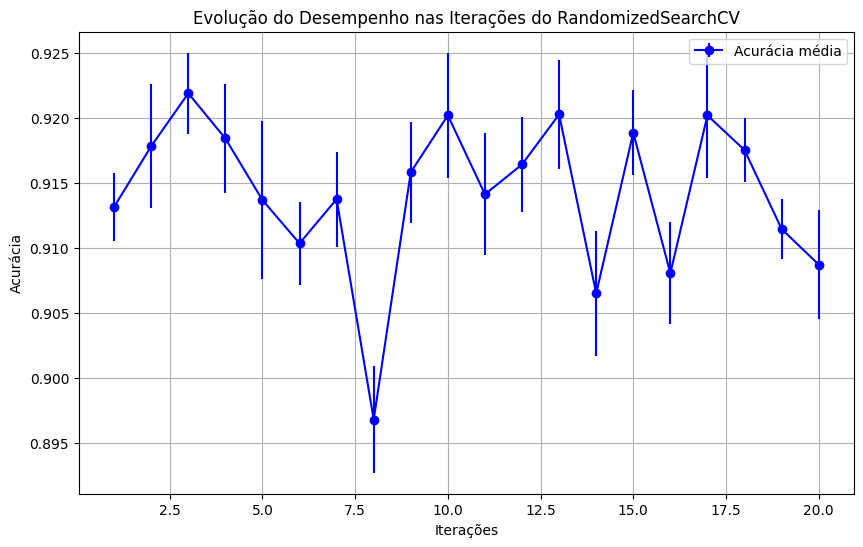

Melhor Acurácia no conjunto de validação: 0.9199206349206349
Melhores parâmetros: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 8, 'min_samples_split': 4}


In [22]:
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, len(mean_scores) + 1), mean_scores, yerr=std_scores, fmt='o', color='b', label='Acurácia média', linestyle='-')
plt.xlabel('Iterações')
plt.ylabel('Acurácia')
plt.title('Evolução do Desempenho nas Iterações do RandomizedSearchCV')
plt.legend()
plt.grid(True)
plt.show()

print(f"Melhor Acurácia no conjunto de validação: {acuracia_val}")
print(f"Melhores parâmetros: {random_search.best_params_}")


In [16]:
melhor_modelo.fit(X_train, y_train)

# Prevendo os resultados no conjunto de teste
y_pred = melhor_modelo.predict(X_test)

# Cálculo das métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro')  # Ajuste conforme o tipo do problema
f1 = f1_score(y_test, y_pred, average='macro')  # Ajuste conforme o tipo do problema

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibindo as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Acurácia: 0.9223
Precisão: 0.5836
Recall: 0.5793
F1-Score: 0.5814


C:\Users\labou\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


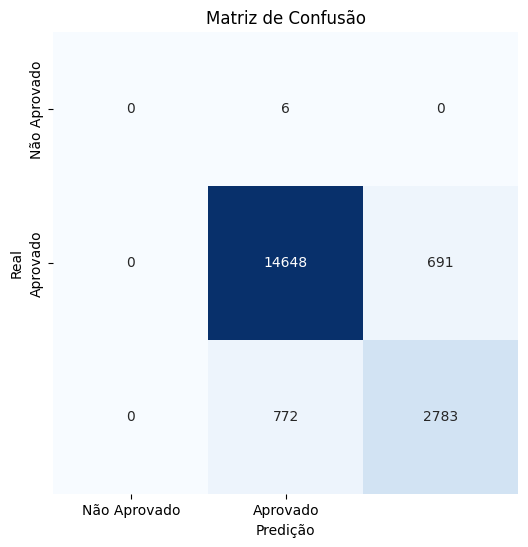

In [17]:
# Plotando a Matriz de Confusão
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Não Aprovado', 'Aprovado'], yticklabels=['Não Aprovado', 'Aprovado'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()